In [1]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [58]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Import modules
import Temperature_Parameters as TP
import Expected_strain as ES
import Rut_calc_RP_v4 as RC_V4
import Fatigue_calc as FC
import IRI_calc

# Start time tracker
start = time.time()

In [59]:
# Rutting functions
def calculate_kz(H_HMA, D):
    C1 = -0.1039 * (H_HMA ** 2) + 2.4868 * H_HMA - 17.342
    C2 = 0.0172 * (H_HMA ** 2) - 1.7331 * H_HMA + 27.428
    with np.errstate(invalid='ignore', divide='ignore'):
        kz = (C1 + C2 * D) * (0.328196 ** D)
        kz = np.where(np.isnan(kz) | np.isinf(kz), 0, kz)
    return kz

def calculate_Wc(Mr, GWT):
    return 51.712 * ((Mr / 2555) ** (1 / 0.64)) ** (-0.3586 * GWT ** 0.1192)

def calculate_beta(W_c):
    return 10 ** (-0.61119 - 0.017638 * W_c)

def calculate_C0(a1, a9, Mr, b1, b9):
    return np.log((a1 * Mr ** b1) / (a9 * Mr ** b9))

def calculate_rho(C0, beta):
    return 10 ** 9 * (C0 / (1 - (10 ** 9) ** beta)) ** (1 / beta)

def calculate_eratio(rho, beta, a1, a9, Mr, b1, b9):
    return (np.exp(rho ** beta) * a1 * Mr ** b1 + np.exp((rho / 10 ** 9) ** beta) * a9 * Mr ** b9) / 2

### **AC Rutting / Total Rut Depth**

In [60]:
# ____________________________________________________________
# AC Layers

epsilon_r_HMA = np.array([-2.98E-04, -2.79E-04, -2.63E-04, -2.54E-04, -2.47E-04,  -2.39E-04,  -2.31E-04,  -2.24E-04,
                          -8.80E-06, -4.86E-05, -6.69E-05, -6.55E-05, -6.35E-05, -6.07E-05, -5.73E-05, -5.44E-05, 
                          -1.25E-05, -2.88E-05, -3.64E-05, -3.70E-05, -3.76E-05, -3.84E-05, -3.97E-05, -4.17E-05, -4.48E-05, -4.95E-05, -5.68E-05, -6.64E-05])  #  in/in

T = np.array([69.80, 69.57, 69.35, 69.12, 69.88, 68.67, 68.45, 68.23,
              68.02, 67.80, 67.60, 67.39, 67.19, 67.01, 66.83, 66.65,
              66.47, 66.31, 66.15, 65.98, 65.80, 65.64, 65.48, 65.34, 65.19, 65.05, 64.94, 64.83])  #temperature in Fahrenheit

Thicks = np.array([6.1, 6.1, 6.2, 6.3, 6.2, 6.3, 6.4 ,6.4, 
                   6.6, 6.6, 6.7, 6.9, 6.9, 7.0, 7.1, 7.2,
                   7.3, 8.0, 8.7, 9.4, 10.2, 11.2, 12, 13.2, 14.3, 15.5, 16.9, 18.3])/25.4  # in mm
H_HMA = 10.0  # total HMA thickness in inches

# ____________________________________________________________
# Granular Layers

e22_granular = np.array([9.72E-06, -2.95E-06, -1.52E-05, -2.52E-05, -3.35E-05, -4.09E-05, -4.78E-05, -5.48E-05, -6.26E-05, -7.19E-05, -8.39E-05, -9.69E-05])  #  in/in
e22_sg = np.array([-7.88E-05, -8.65E-05, -9.23E-05, -9.59E-05, -9.71E-05, -9.60E-05, -9.27E-05, -8.92E-05, -4.39E-05])#  in/in

Thicks_granular = np.array([18.9, 19.9, 21.0, 22.0, 23.2, 24.4, 25.7, 27.0, 28.4, 29.9, 31.5, 33.10,])/25.4  #  in mm
Thicks_sg = np.array([33.90, 39.60, 46.4, 54.4, 63.60, 74.5, 87.2, 102.1, 3943.3])/25.4

Mr_granular = 400 * 145.037738 # convert from MPa to psi
Mr_sg = 70 * 145.037738 # convert from MPa to psi

In [61]:
# AC RUTTING
def rut_AC(epsilon_r_HMA, T, Thicks, H_HMA, Rut_tol=-0.50):
    # Cumulative Depths
    D = np.cumsum(Thicks)
    # Constants from the NCHRP 1-40D recalibration
    
    kz = calculate_kz(H_HMA, D)

    def rut_sum(N):
        k1r = -3.35412
        k2r = 0.4791
        k3r = 1.5606
        beta1r = 1.00
        beta2r = 1.00
        beta3r = 1.00
        Rut = beta1r * kz * epsilon_r_HMA * (10 ** k1r) * (N ** (k2r * beta2r)) * (T ** (k3r * beta3r))
        return np.abs(np.sum(Rut) - Rut_tol)
    
    result = minimize_scalar(rut_sum, bounds=(1, 1e10), method='bounded')
    return int(result.x)

# TOTAL RUTTING 
def rut_total(epsilon_r_HMA, e22_granular, e22_sg, T, Thicks, Thicks_granular, Thicks_sg, H_HMA, Rut_tol):
    # Cumulative Depths
    D = np.cumsum(Thicks)

    # Constants from the NCHRP 1-40D recalibration   
    k1r = -3.35412
    k2r = 0.4791
    k3r = 1.5606
    beta1r = 1.00
    beta2r = 1.00
    beta3r = 1.00
    
    kz = calculate_kz(H_HMA, D)

    # Constants
    k1r, k2r, k3r = -3.35412, 0.4791, 1.5606
    beta1r, beta2r, beta3r = 1.00, 1.00, 1.00
    betas1, ks1 = 1.00, 0.965
    a1, a9, b1, b9 = 0.15, 20.0, 0.0, 0.0
    GWT = 20
    
    def material_properties(Mr, Thicks):
        Wc = calculate_Wc(Mr, GWT)
        C0 = calculate_C0(a1, a9, Mr, b1, b9)
        beta = calculate_beta(Wc)
        rho = calculate_rho(C0, beta)
        eratio = calculate_eratio(rho, beta, a1, a9, Mr, b1, b9)
        return Wc, C0, beta, rho, eratio
    
    Wc_granular, C0_granular, beta_granular, rho_granular, eratio_granular = material_properties(Mr_granular, Thicks_granular)
    Wc_sg, C0_sg, beta_sg, rho_sg, eratio_sg = material_properties(Mr_sg, Thicks_sg)
    
    def rut_sum(N): 
        Rut = beta1r * kz * epsilon_r_HMA * (10 ** k1r) * (N ** (k2r * beta2r)) * (T ** (k3r * beta3r))
        Rut_granular = betas1 * ks1 * e22_granular * Thicks_granular * eratio_granular * np.exp(-(rho_granular/N)**beta_granular)
        Rut_sg = betas1 * ks1 * e22_sg * Thicks_sg * eratio_sg * np.exp(-(rho_sg/N)**beta_sg)
        return np.abs(np.sum(Rut) + np.sum(Rut_granular) + np.sum(Rut_sg) - Rut_tol)
    
    result = minimize_scalar(rut_sum, bounds=(1, 1e10), method='bounded')
    return int(result.x)

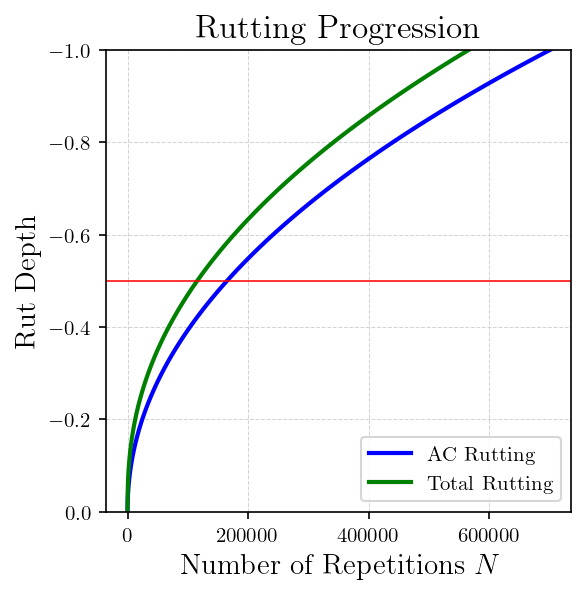

In [64]:
# Now plot the rutting for different Rut_tol values
Rut_tol_values = np.linspace(0, -1.0, 100)
rut_hma = [rut_AC(epsilon_r_HMA, T, Thicks, H_HMA, Rut_tol) for Rut_tol in Rut_tol_values]
rut_tot = [rut_total(epsilon_r_HMA, e22_granular, e22_sg, T, Thicks, Thicks_granular, Thicks_sg, H_HMA, Rut_tol) for Rut_tol in Rut_tol_values]

fig = plt.figure(figsize=(4, 4), dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(rut_hma, Rut_tol_values, color='blue', linewidth=2.0, label = 'AC Rutting')
plt.plot(rut_tot, Rut_tol_values, color='green', linewidth=2.0, label = 'Total Rutting ')
plt.axhline(-0.5, color='red', linewidth=0.75)   # Threshold IRI
plt.xlabel('Number of Repetitions $N$', fontsize = 14)
plt.ylabel('Rut Depth', fontsize=14)
plt.title('Rutting Progression', fontsize=16, fontweight='bold')
plt.ylim(-1.0, 0.0)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.show()